In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2

C:\Users\jiaha\anaconda3\envs\tensorflow\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append("../..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "../../sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam = sam.to(device)

In [5]:
import os
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from segment_anything.utils.transforms import ResizeLongestSide

class PeoplePosesDataset(Dataset):
    def __init__(self, device, mode="train", img_size=1024):
        assert mode in ("train", "val")
        self.mode = mode
        self.root = "../../datasets/people_poses"
        self.image_dir = os.path.join(self.root, f"{self.mode}_images")
        self.mask_dir = os.path.join(self.root, f"{self.mode}_segmentations")
        self.embed_dir = os.path.join(self.root, f"{self.mode}_embeds")
        os.makedirs(self.embed_dir, exist_ok = True) 
        with open(os.path.join(self.root, f"{self.mode}_id.txt"), 'r') as lf:
            self.data_list = [ s.strip() for s in lf.readlines() ]
        self.img_size = img_size
        self.transform = ResizeLongestSide(img_size)
        self.device = device

    def __len__(self):
        return len(self.data_list)

    def preprocess(self, x):
        # TODO(jiahang): clean up this dependency issue
        x = (x - sam.pixel_mean) / sam.pixel_std

        h, w = x.shape[-2:]
        padh = self.img_size - h
        padw = self.img_size - w
        x = F.pad(x, (0, padw, 0, padh))
        return x
    
    def __getitem__(self, index):
        image = cv2.imread(os.path.join(self.image_dir, self.data_list[index] + ".jpg"))
        label = cv2.imread(os.path.join(self.mask_dir, self.data_list[index] + ".png"))
        image = self.transform.apply_image(image[..., ::-1])
        H, W, C = image.shape
        image = torch.as_tensor(image, device=self.device)
        image = image.permute(2, 0, 1).contiguous()[None, :, :, :]
        image = self.preprocess(image)

        label = torch.as_tensor(label, device=self.device)
        label = label.permute(2, 0, 1).contiguous()[None, :, :, :]
        label = F.interpolate(label, (H, W), mode='nearest')
        label = label.to(torch.int64)
        label = F.pad(label, (0, self.img_size - W, 0, self.img_size - H), value=-1)
        
        # torch.Size([3, 1024, 1024]), torch.Size([1024, 1024]), string
        return image[0],  label[0][0], os.path.join(self.embed_dir, self.data_list[index] + ".npz")

"""
x, y = next(iter(dataloader))
x.shape, y.shape, x.dtype, y.dtype
(torch.Size([8, 3, 1024, 1024]),
 torch.Size([8, 1024, 1024]),
 torch.float32,
 torch.int8)
"""
dataset = PeoplePosesDataset(device)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

## Debug

In [3]:
sam.pixel_mean

tensor([[[123.6750]],

        [[116.2800]],

        [[103.5300]]], device='cuda:0')

In [4]:
sam.pixel_std

tensor([[[58.3950]],

        [[57.1200]],

        [[57.3750]]], device='cuda:0')

In [6]:
images, labels, paths = next(iter(dataloader))
images.shape, labels.shape, paths

(torch.Size([1, 3, 1024, 1024]),
 torch.Size([1, 1024, 1024]),
 ('../../datasets/people_poses\\train_embeds\\1000_1234574.npz',))

In [8]:
for image, label, path in zip(images, labels, paths):
    print(image.shape, label.shape, path)

torch.Size([3, 1024, 1024]) torch.Size([1024, 1024]) ../../datasets/people_poses\train_embeds\1000_1234574.npz


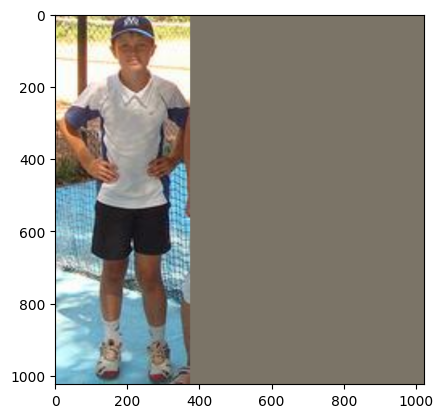

In [14]:
plt.imshow((images[0] * sam.pixel_std + sam.pixel_mean).permute(1, 2, 0).cpu().numpy().astype(np.uint8))

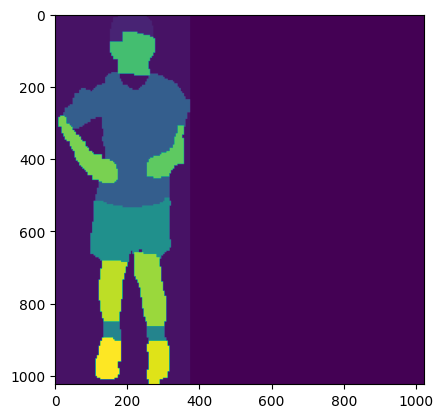

In [22]:
plt.imshow(labels[0].cpu().numpy() + 1)

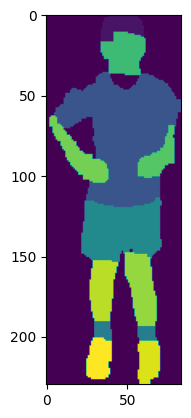

In [25]:
label_ = cv2.imread("../../datasets/people_poses/train_segmentations/1000_1234574.png")
plt.imshow(label_[:,:,0])

In [19]:
labels.min(), labels.max(), labels.dtype

(tensor(-1, device='cuda:0'), tensor(19, device='cuda:0'), torch.int64)

## Generate Embedding

In [5]:
from tqdm import tqdm

for data in tqdm(dataloader):
    images, labels, paths = data
    with torch.no_grad():
        embeds = sam.image_encoder(images)
    for embed, label, path in zip(embeds, labels, paths):
        np.savez_compressed(path,
                            embed=embed.cpu().numpy(),
                            label=label.cpu().numpy())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30462/30462 [12:45:56<00:00,  1.51s/it]


In [6]:
val_dataset = PeoplePosesDataset(device, mode='val')
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
for data in tqdm(val_dataloader):
    images, labels, paths = data
    with torch.no_grad():
        embeds = sam.image_encoder(images)
    for embed, label, path in zip(embeds, labels, paths):
        np.savez_compressed(path,
                            embed=embed.cpu().numpy(),
                            label=label.cpu().numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [4:11:52<00:00,  1.51s/it]
